In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_baseVal = pd.read_csv('Udacity_ABTest_BaselineValues.csv', header = None, names = ['Name','Val'])
df_baseVal

,Name,Val
0,Unique cookies to view course overview page pe...,40000.000000
1,"Unique cookies to click ""Start free trial"" per...",3200.000000
2,Enrollments per day:,660.000000
3,"Click-through-probability on ""Start free trial"":",0.080000
4,"Probability of enrolling, given click:",0.206250
5,"Probability of payment, given enroll:",0.530000
6,"Probability of payment, given click",0.109313


In [19]:
#Given sample size of 5000 cookies, the standard deviations of Gross conversion, Retention, Net conversion
#binomial distribution, SE = sqrt(p*(1-p)/N) round to 4-digit
p_list = [df_baseVal['Val'][4], df_baseVal['Val'][5], df_baseVal['Val'][6]]
print('Analytical Estimate of SE of Gross conversion, Retention, Net conversion:', [round(np.sqrt(p*(1-p)/400),4) for p in p_list])

Analytical Estimate of SE of Gross conversion, Retention, Net conversion: [0.0202, 0.025, 0.0156]


In [84]:
#sample size in unit of number of clicks / enrolls
# pooled sample standard error: SE = sqrt(p*(1-p)/(1/N1 + 2/N2)),here N1 = N2 = N
# alpha = 0.5, considering two tailed Bonferroni correction, alpha = 0.5/2/2 = 0.125, corresponding Z score = 2.24
# alpha was originally calculated as 0.5/3/2, but later the rentention was not used since it requires to0 large sample sizes
# beta = 0.2, power = 0.8, corresponding to Z score = 0.84
# sample size doulbe since need two, one for control, one for experiment
Z_total = 2.24 + 0.84
d_list = [0.01, 0.01, 0.0075]
size_unit=[round(Z_total**2*p*(1-p)*2/d**2)*2 for p,d in list(zip(p_list, d_list))]

In [85]:
# factor to pageviews
ratio = [df_baseVal['Val'][0]/df_baseVal['Val'][1],df_baseVal['Val'][0]/df_baseVal['Val'][2],df_baseVal['Val'][0]/df_baseVal['Val'][1]]
size_pageviews = np.round(np.array(size_unit) * np.array(ratio))
list(size_pageviews)

[776525.0, 5728606.0, 821000.0]

In [73]:
#Gross conversion, Retention, Net conversion, with alpha = 0.5/2/2
size_pageviews_needed = max(size_pageviews[0],size_pageviews[2])
print(size_pageviews_needed)

821000.0


In [74]:
fraction_traffic = 0.8
days_needed = round(size_pageviews_needed/fraction_traffic/40000)
print(days_needed)

26.0


In [3]:
#sanity check
df_exp = pd.read_csv('Udacity_ABTest_ExpData.csv')
df_con = pd.read_csv('Udacity_ABTest_ControlData.csv')
df_exp.describe()

,Pageviews,Clicks,Enrollments,Payments
count,37.000000,37.000000,23.000000,23.000000
mean,9315.135135,765.540541,148.826087,84.565217
std,708.070781,64.578374,33.234227,23.060841
min,7664.000000,642.000000,94.000000,34.000000
25%,8881.000000,722.000000,127.000000,69.000000
50%,9359.000000,770.000000,142.000000,91.000000
75%,9737.000000,827.000000,172.000000,99.000000
max,10551.000000,884.000000,213.000000,123.000000


In [4]:
df_con.sum()

Date           Sat, Oct 11Sun, Oct 12Mon, Oct 13Tue, Oct 14We...
Pageviews                                                 345543
Clicks                                                     28378
Enrollments                                                 3785
Payments                                                    2033
dtype: object

In [5]:
d = {'control': df_con.sum().iloc[1:], 'exp': df_exp.sum().iloc[1:]}
df = pd.DataFrame(data = d)

In [6]:
df[['control', 'exp']] = df[['control','exp']].apply(pd.to_numeric)
df['total_counts'] = df.control + df.exp
df['p_expected'] = 0.5
df['p_observed'] = df.control.div(df.total_counts)
df['SE'] = (df.p_expected * (1-df.p_expected)/df.total_counts).pow(.5)
df['margin'] = df.SE * 1.96
df['CI_low'] = df.p_expected - df.margin
df['CI_upp'] = df.p_expected + df.margin
df['sanity_pass?'] = (df.p_observed > df.CI_low) & (df.p_observed < df.CI_upp)
df

,control,exp,total_counts,p_expected,p_observed,SE,margin,CI_low,CI_upp,sanity_pass?
Pageviews,345543,344660,690203,0.5,0.500640,0.000602,0.001180,0.498820,0.501180,True
Clicks,28378,28325,56703,0.5,0.500467,0.002100,0.004116,0.495884,0.504116,True
Enrollments,3785,3423,7208,0.5,0.525111,0.005889,0.011543,0.488457,0.511543,False
Payments,2033,1945,3978,0.5,0.511061,0.007928,0.015538,0.484462,0.515538,True


In [7]:
# CTP sanity check CTP = Clicks/Pageviews for UNIQUE cookies
p_ctp_expected = df.control.Clicks /df.control.Pageviews
p_ctp_observed = df.exp.Clicks /df.exp.Pageviews
SE_ctp = np.sqrt(p_ctp_expected*(1-p_ctp_expected)/df.control.Pageviews) #binomial
CI_ctp_low = p_ctp_expected - 1.96*SE_ctp
CI_ctp_upp = p_ctp_expected + 1.96*SE_ctp
print('CTP expected',round(p_ctp_expected,4),'CTP observed:', round(p_ctp_observed,4), 'CI:', round(CI_ctp_low,4), round(CI_ctp_upp,4))
print('CTP Sanity:', CI_ctp_low < p_ctp_observed < CI_ctp_upp)

CTP expected 0.0821 CTP observed: 0.0822 CI: 0.0812 0.083
CTP Sanity: True


In [8]:
d_effect = {'con_click': df_con.Clicks, 'con_enroll':df_con.Enrollments, 'con_pay':df_con.Payments,
     'exp_click': df_exp.Clicks, 'exp_enroll':df_exp.Enrollments, 'exp_pay':df_exp.Payments}
df_effect = pd.DataFrame(data = d_effect)
df_effect.head()

,con_click,con_enroll,con_pay,exp_click,exp_enroll,exp_pay
0,687,134.0,70.0,686,105.0,34.0
1,779,147.0,70.0,785,116.0,91.0
2,909,167.0,95.0,884,145.0,79.0
3,836,156.0,105.0,827,138.0,92.0
4,837,163.0,64.0,832,140.0,94.0


In [9]:
df_effect.dropna(axis=0, how='any', inplace = True)
df_effect.shape

(23, 6)

In [17]:
#empirical deviations
d_empirical = {'gross_conv': df_effect.con_enroll/df_effect.con_click, 'retention':df_effect.con_pay/df_effect.con_enroll, 'net_conv': df_effect.con_pay/df_effect.con_click}
df_empirical = pd.DataFrame(data = d_empirical)
print('empirical estimation of deviations:')
round(df_empirical.std(),4)

empirical estimation of deviations:


gross_conv    0.0440
retention     0.0943
net_conv      0.0294
dtype: float64

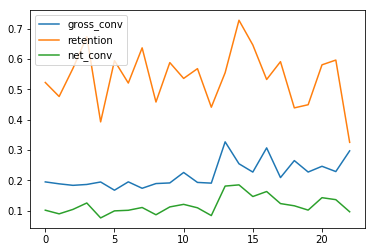

In [20]:
df_empirical.plot()

<Figure size 2160x2160 with 0 Axes>

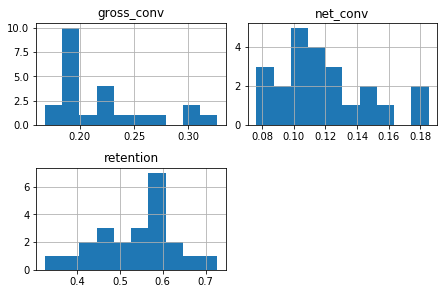

In [18]:
plt.figure(figsize=(30,30))
df_empirical.hist()
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [199]:
df_effect.sum()

con_click     17293.0
con_enroll     3785.0
con_pay        2033.0
exp_click     17260.0
exp_enroll     3423.0
exp_pay        1945.0
dtype: float64

In [196]:
df_effect.sum().con_click

17293.0

In [102]:
#Effect Size Tests
#Gross conversion = enroll/click
#Net conversion = pay/click
d_ci = {'val_con':[df_effect.sum().con_enroll/df_effect.sum().con_click, df_effect.sum().con_pay/df_effect.sum().con_click],\
         'val_exp':[df_effect.sum().exp_enroll/df_effect.sum().exp_click, df_effect.sum().exp_pay/df_effect.sum().exp_click],\
         'val_avg':[(df_effect.sum().con_enroll+df_effect.sum().exp_enroll)/(df_effect.sum().con_click+df_effect.sum().exp_click), \
                    (df_effect.sum().con_pay+df_effect.sum().exp_pay)/(df_effect.sum().con_click+df_effect.sum().exp_click)]}
df_ci= pd.DataFrame(data = d_ci)
df_ci.rename({0:'gross', 1:'net'}, axis = 'index', inplace = True)

In [103]:
df_ci['v_diff'] = df_ci.val_exp - df_ci.val_con
df_ci['SE'] =  np.sqrt(df_ci.val_avg * (1- df_ci.val_avg) *(1/df_effect.sum().con_click + 1/df_effect.sum().exp_click))
df_ci['margin'] = 2.24*df_ci.SE  #alpha = 0.05/2/2

In [104]:
df_ci['ci_low'] = df_ci.v_diff - df_ci.margin
df_ci['ci_upp'] = df_ci.v_diff + df_ci.margin
df_ci['statistic_significance'] = df_ci.ci_low * df_ci.ci_upp > 0
df_ci['practical_significance'] = [(df_ci.ci_low.gross * df_ci.ci_upp.gross > 0) and (min(abs(df_ci.ci_low.gross), abs(df_ci.ci_upp.gross))>=0.01),\
(df_ci.ci_low.net * df_ci.ci_upp.net > 0) and (min(abs(df_ci.ci_low.net), abs(df_ci.ci_upp.net)) > 0.0075)]

In [105]:
df_ci['test']= [1,2]
df_ci.drop(columns = 'test', inplace = True)

In [106]:
df_ci

,val_con,val_exp,val_avg,v_diff,SE,margin,ci_low,ci_upp,statistic_significance,practical_significance
gross,0.218875,0.198320,0.208607,-0.020555,0.004372,0.009793,-0.030347,-0.010762,True,True
net,0.117562,0.112688,0.115127,-0.004874,0.003434,0.007692,-0.012566,0.002819,False,False


In [267]:
#sign test, combine the possibilities of observing 19 or more successes in 23 trials
df_effect[df_effect.con_enroll > df_effect.exp_enroll].count()

con_click     19
con_enroll    19
con_pay       19
exp_click     19
exp_enroll    19
exp_pay       19
dtype: int64

Sign and binomial test
Number of "successes": 19 
Number of trials (or subjects) per experiment: 23 
Sign test. If the probability of "success" in each trial or subject is 0.500, then:
The one-tail P value is 0.0013 
This is the chance of observing 19 or more successes in 23 trials.
The two-tail P value is 0.0026 
This is the chance of observing either 19 or more successes, or 4 or fewer successes, in 23 trials.

In [269]:
df_effect[df_effect.con_pay > df_effect.exp_pay].count()

con_click     13
con_enroll    13
con_pay       13
exp_click     13
exp_enroll    13
exp_pay       13
dtype: int64

Sign and binomial test
Number of "successes": 13 
Number of trials (or subjects) per experiment: 23 
Sign test. If the probability of "success" in each trial or subject is 0.500, then:
The one-tail P value is 0.3388 
This is the chance of observing 13 or more successes in 23 trials.
The two-tail P value is 0.6776 
This is the chance of observing either 13 or more successes, or 10 or fewer successes, in 23 trials.